In [14]:
%matplotlib notebook
import os
import os.path as path
import pandas as pd
import h5py
import numpy as np
from faker import Factory
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
import plotly

# Local module and scripts
from pyccapt.calibration.calibration_tools import data_tools, variables, tools
from pyccapt.calibration.calibration_tools import reconstruction
from pyccapt.calibration.calibration_tools import widgets as wd


In [2]:
number_sample = 300
save_fig=False
plot_fig=True 

In [3]:
# flightPathLength = 110 # mm 
# # The initial value for t_0
# t0 = 51.74 # ns

# dataset name
# AL_data_b
# OLO_AL_6_data
# OLO_W_6_data
# OLO_Ni_8_data
# X6Cr17_2V30Min_5_data
# data_1029_Jun-27-2022_15-53_Pd
# data_115_Jul-27-2022_17-44_Powersweep3

In [4]:
tdc, dataset, flightPathLength_d, t0_d = wd.dataset_tdc_selection()
display(tdc, dataset, flightPathLength_d, t0_d)

Dropdown(description='TDC model:', options=('surface_concept', 'roentdec'), value='surface_concept')

Text(value='OLO_AL_6_data', description='Dataset:', placeholder='Paste ticket description here!')

Text(value='110', description='Flight path length:', placeholder='Flight path length')

Text(value='51.74', description='t0:', placeholder='T_0 of the instrument')

$$\textbf{You can specify which dataset to use in below block}$$

In [5]:
tdc_model = tdc.value

dataset_name = dataset.value

flightPathLength = float(flightPathLength_d.value) # mm 
# The initial value for t_0
t0 = float(t0_d.value) # ns

p = path.abspath(path.join("", "../../../.."))

variables.init()

path_main = os.path.join(p, 'tests//data')
filename_main = path_main + '//' + dataset_name + '.h5'

variables.path = os.path.join(p, 'tests//results//load_crop')
variables.result_path = os.path.join(p, 'tests/results/tof_calibratin/' + dataset_name)
if not os.path.isdir(variables.result_path):
        os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
        
filename = variables.path + '//' + dataset_name + '//' + dataset_name + '_cropped' + '.h5'



head, tail = os.path.split(filename)
figname = os.path.splitext(tail)[0]

data = data_tools.read_hdf5_through_pandas(filename)


dld_highVoltage = data['dld/high_voltage'].to_numpy()
dld_pulseVoltage = data['dld/pulse_voltage'].to_numpy()
dld_t = data['dld/t'].to_numpy()
dld_x = data['dld/x'].to_numpy()
dld_y = data['dld/y'].to_numpy()

In [6]:
data

,dld/high_voltage,dld/pulse_voltage,dld/start_counter,dld/t,dld/x,dld/y
0,5261.248047,5261.248047,9299.0,634.893066,5.985306,-22.763265
1,5261.248047,5261.248047,9551.0,467.893908,-3.629388,17.032653
2,5261.248047,5261.248047,10161.0,649.486890,-17.828571,23.973061
3,5261.248047,5261.248047,10358.0,646.016742,19.038367,20.980408
4,5261.248047,5261.248047,10581.0,632.588778,22.476735,-6.176327
...,...,...,...,...,...,...
1822981,5708.472656,5708.472656,26372.0,618.042960,-19.993469,-22.922449
1822982,5708.472656,5708.472656,26455.0,612.954324,13.180408,18.751837
1822983,5708.472656,5708.472656,26564.0,453.642984,-8.309388,20.725714
1822984,5708.472656,5708.472656,26777.0,605.561400,18.274286,11.111020


In [7]:
mc_oxcart = np.array(pd.DataFrame(np.array(h5py.File(filename)['cropped_dld']['mc'])))


09-12-2022 15:17:55 | INFO | Selected Mode = count
09-12-2022 15:17:55 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


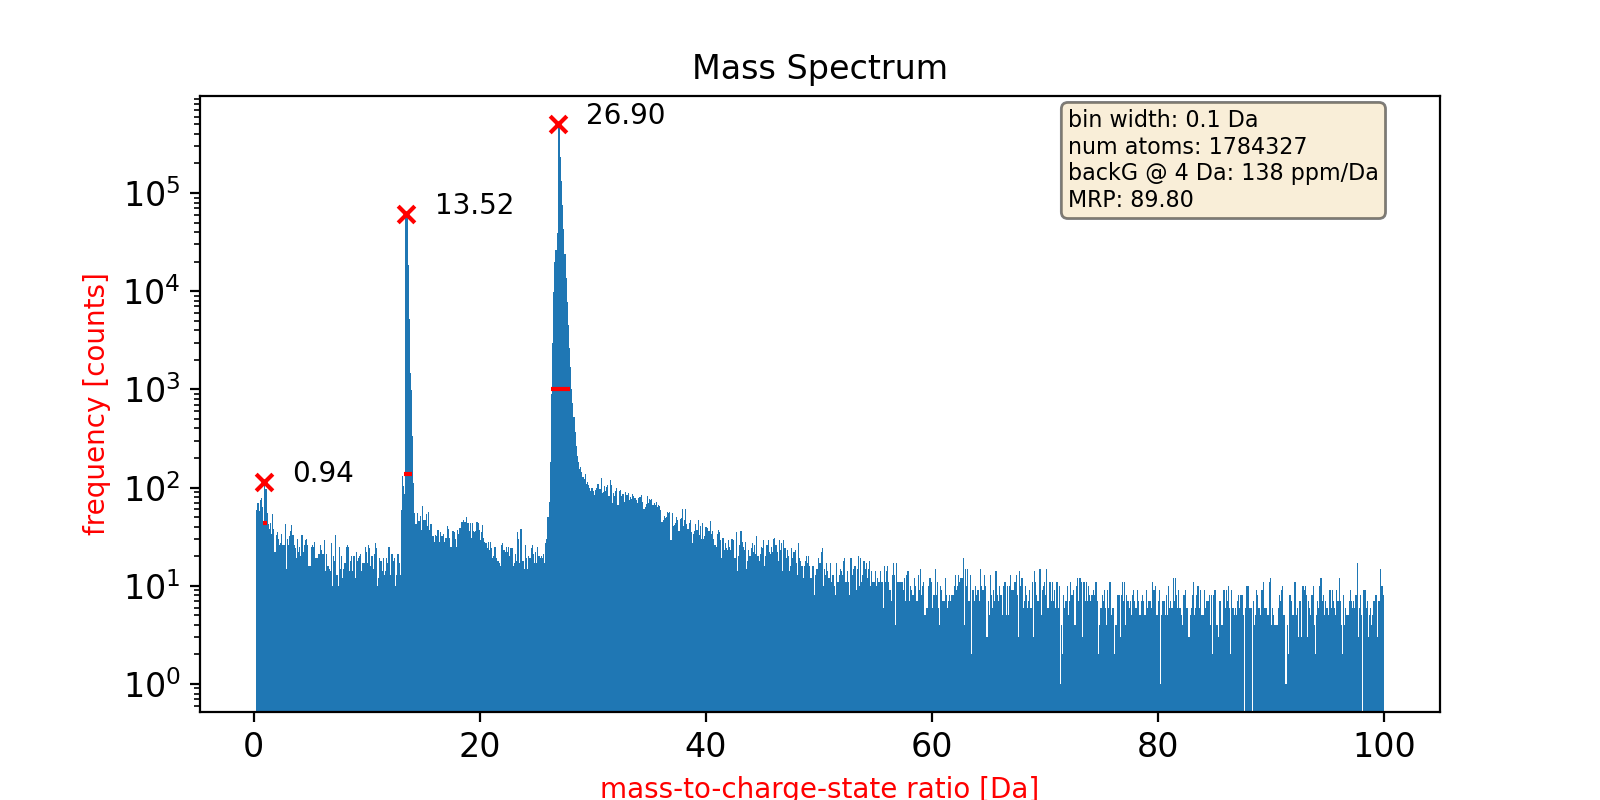

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [89.79972061]
Peaks  0 is: 0.94 peak window sides are: 0.84 - 1.14
Peaks  1 is: 13.52 peak window sides are: 13.32 - 13.62
Peaks  2 is: 26.90 peak window sides are: 26.80 - 27.10


In [8]:
max_hist_p, left_right_peaks_p, peaks_sides_p, max_paek_edges_p, index_max_p = tools.massSpecPlot(mc_oxcart[mc_oxcart < 100], 0.1, prominence=50, distance=100, text_loc='right', percent=50, plot=True, fig_name='oxcart_mc'+figname)
mrp = (max_hist_p / (left_right_peaks_p[1] - left_right_peaks_p[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_p)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_p[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_p[i,2], peaks_sides_p[i,3]))

In [10]:
fake = Factory.create()
color = np.chararray(len(mc_oxcart), itemsize=7, unicode=True)
color[:] = fake.hex_color()
for peak in range(len(peaks_sides_p)):
    mask = np.logical_and((peaks_sides_p[peak,2] < mc_oxcart), (mc_oxcart < peaks_sides_p[peak,3]))
    color[mask.squeeze() == True] = fake.hex_color()

In [38]:
r = dld_highVoltage / (1.4* (65/1E-9))

In [39]:
r

array([5.78159126e-08, 5.78159126e-08, 5.78159126e-08, ...,
       6.27304688e-08, 6.27304688e-08, 6.27304688e-08])

In [40]:
110*1E-2 / (3.0 * r)

array([6341967.98352537, 6341967.98352537, 6341967.98352537, ...,
       5845112.81316811, 5845112.81316811, 5845112.81316811])

In [11]:
x, y, z = reconstruction.atom_probe_recons_from_detector(dld_x, dld_y, dld_highVoltage, 110, kf=3.0, det_eff=50, icf=1.4, Fevap=65, avgDens=60.2)

In [20]:
print(np.max(x), np.min(x))
print(np.max(y), np.min(y))
print(np.max(z), np.min(z))

35.41072838924577 0.0
1.2226013128003703 -1.2132647884445011
1.3976997607477317e+17 69624159149.88144


In [ ]:
# Al = 10 cm3/mol - H = 14.4 cm3/mol
x, y, z = reconstruction.atom_probe_recons_pad(detx, dety, dld_v, flight_path_length, ion_volume, radius=55*1E-9, Fevap=65, det_eff=50, kf=3.0, icf=1.4)

In [12]:
phases = ['H', 'Al2+', 'Al+']

In [17]:
plotly_data = list()
for element in phases:
    scatter = dict(
        mode="markers",
        name=element,
        type="scatter3d",
        x=x, y=y, z=z,
        opacity = 0.2,
        marker = dict(size=2, color=color)
    )
    plotly_data.append(scatter)

layout = dict(
    title = 'APT 3D Point Cloud',
    scene = dict(xaxis = dict(zeroline=False),
                yaxis = dict(zeroline=False),
                zaxis = dict(zeroline=False, autorange='reversed'))
)

fig = dict(data=plotly_data, layout=layout)

init_notebook_mode(connected=True)  
plotly.offline.plot(fig, filename='{fn}.html'.format(fn=filename), show_link=False)
iplot(fig)

<IPython.core.display.Javascript object>


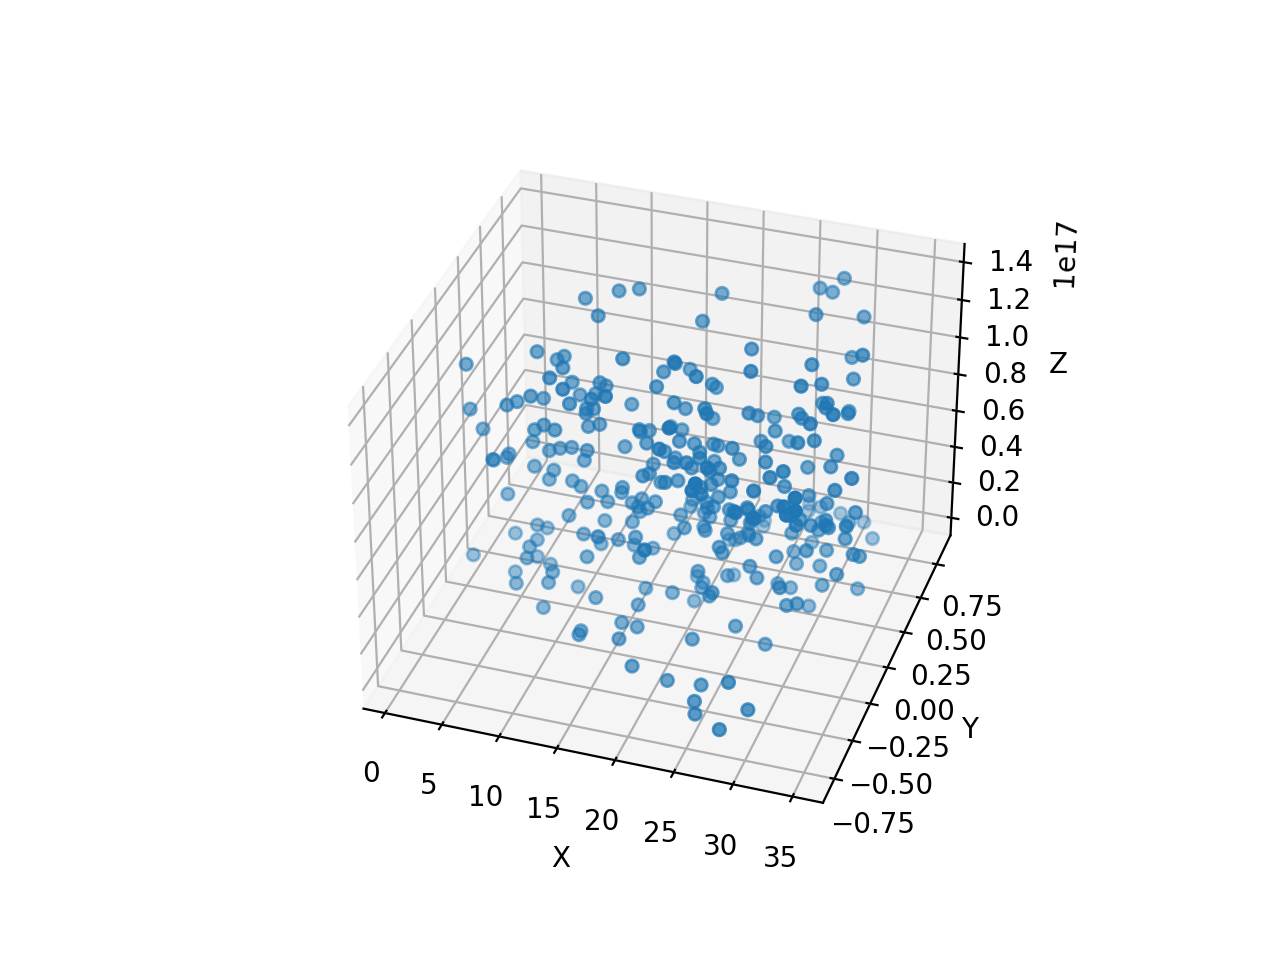

In [18]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

mask = np.random.randint(0, len(z), 300)
ax.scatter(x[mask], y[mask], z[mask])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()